In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelo Específico
from sklearn.ensemble import RandomForestClassifier

# Métricas
from sklearn.metrics import (classification_report, roc_auc_score, RocCurveDisplay,
                             ConfusionMatrixDisplay, precision_score, recall_score,
                             f1_score, confusion_matrix, precision_recall_curve)

# Balanceo
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.tree import export_text

In [24]:
# CONFIGURACIÓN
SEED = 42
DATA_DIR = 'Data/' # Ajusta si tus archivos están en otra carpeta

# Umbral de decisión (Ajustable: > 0.5 para más precisión, < 0.5 para más recall)
UMBRAL_CORTE = 0.6752

pd.set_option('display.max_columns', None)

# Configuración Visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [25]:
# Archivos

MODELOCL = 'CL'
MODELOAR = 'DOMAR'
MODELOPE = 'DOMPE'
MODELOCO = 'DOMCO'
MODELOIN = 'INTER'


In [26]:
# Parámetros base para Random Forest
PARAMS_ESTATICOS = {
    'GENERAL': {
        'class_weight': 'balanced',
        'max_depth': 20,
        'min_samples_leaf': 4,
        'min_samples_split': 2,
        'n_estimators': 500
    },
    'CL':     {
        'class_weight': 'balanced',
        'max_depth': 12,
        'min_samples_leaf': 4,
        'min_samples_split': 2,
        'n_estimators': 400
    },
    'PE':     {
        'class_weight': 'balanced',
        'max_depth': 20,
        'min_samples_leaf': 1,
        'min_samples_split': 2,
        'n_estimators': 500
    },
    'CO':     {
        'class_weight': 'balanced',
        'max_depth': 12,
        'min_samples_leaf': 4,
        'min_samples_split': 2,
        'n_estimators': 500
    },
    'AR':     {
        'class_weight': 'balanced',
        'max_depth': 20,
        'min_samples_leaf': 1,
        'min_samples_split': 2,
        'n_estimators': 400
    }
}
PARAMS_OPTIMIZADOS = {
    'GENERAL': {'class_weight': 'balanced', 'n_estimators': 500, 'max_depth': 22, 'min_samples_split': 15, 'min_samples_leaf': 10},
    'CL': {'class_weight': 'balanced', 'n_estimators': 800, 'max_depth': 19, 'min_samples_split': 15, 'min_samples_leaf': 2},
    'PE': {'class_weight': 'balanced', 'n_estimators': 200, 'max_depth': 22, 'min_samples_split': 20, 'min_samples_leaf': 11},
    'CO': {'class_weight': 'balanced', 'n_estimators': 200, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 6},
    'AR': {'class_weight': 'balanced', 'n_estimators': 400, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 1}
}

In [27]:
def matriz_correlacion(pack_modelo, X, feature_names=None, top_n=37):
    model = pack_modelo['model']

    # 1. Obtener importancias (RandomForest)
    importancias = getattr(model, "feature_importances_", None)
    if importancias is None:
        raise ValueError("El modelo no tiene 'feature_importances_'. Asegúrate de pasar un RandomForest entrenado.")

    # 2. Crear DataFrame de features
    if isinstance(X, pd.DataFrame):
        df_X = X.copy()
    else:
        if feature_names is None:
            feature_names = [f"f_{i}" for i in range(X.shape[1])]
        df_X = pd.DataFrame(X, columns=feature_names)

    # 3. Selección top_n (o todas si top_n es None)
    if top_n is None or top_n >= df_X.shape[1]:
        cols_top = list(df_X.columns)
    else:
        # manejar posible desajuste de tamaño
        n_feats = min(len(importancias), df_X.shape[1])
        importancias = importancias[:n_feats]
        indices_top = np.argsort(importancias)[::-1][:top_n]
        cols_top = [df_X.columns[i] for i in indices_top]

    df_top = df_X[cols_top]

    # 4. Calcular Correlación (Pearson)
    corr = df_top.corr()

    # 5. Graficar
    plt.figure(figsize=(20, 12))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True, cbar_kws={'shrink': .8}, annot_kws={'size':8})
    plt.title(f"Matriz de Correlación (Top {len(cols_top)} Variables)")
    plt.tight_layout()
    plt.show()

    return corr


In [28]:
def entrenar_rf_visual(X_train, X_test, y_train, y_test, nombre_modelo, params):

    print(f"PROCESANDO RANDOM FOREST: {nombre_modelo}")
    print(f"{'='*60}")

    # 1. Separar parámetros del modelo de los nuestros
    rf_params = {k: v for k, v in params.items() if k != 'usar_smote' and k != 'threshold'}

    # 2. Aplicar SMOTE (Balanceo)
    if params.get('usar_smote', False):
        print(f"-> Aplicando SMOTE (Balanceo Sintético)...")
        smote = SMOTE(random_state=SEED)
        X_train_final, y_train_final = smote.fit_resample(X_train, y_train)
    else:
        X_train_final, y_train_final = X_train, y_train

    # 3. Entrenar Modelo
    print(f"-> Entrenando bosque con {rf_params.get('n_estimators', '??')} árboles...")
    model = RandomForestClassifier(**rf_params)
    model.fit(X_train_final, y_train_final)

    # 4. Predicciones (Probabilidades)
    probs_test = model.predict_proba(X_test)[:, 1]

    # USAR UMBRAL FIJO (sin optimización automática)
    mejor_umbral = params.get('threshold', UMBRAL_CORTE)
    preds = (probs_test >= mejor_umbral).astype(int)

    # 5. Métricas y Reportes
    auc = roc_auc_score(y_test, probs_test)

    print(f"\nREPORTE FINAL ({nombre_modelo})")
    print(classification_report(y_test, preds, target_names=['Ocio', 'Trabajo']))
    print(f"AUC-ROC Score: {auc:.4f}")

    # 6. Gráficos
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Matriz de Confusión
    cm = confusion_matrix(y_test, preds)
    ConfusionMatrixDisplay(cm, display_labels=['Ocio', 'Trabajo']).plot(ax=ax[0], cmap='Greens')
    ax[0].set_title(f"Matriz de Confusión (Corte: {mejor_umbral:.2f})")
    ax[0].grid(False)

    # Curva ROC
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax[1], name=nombre_modelo)
    ax[1].plot([0, 1], [0, 1], 'k--')
    ax[1].set_title("Curva ROC")

    plt.tight_layout()
    plt.show()

    return {'model': model}

In [29]:
def graficar_importancia_rf(pack_modelo, feature_names, top_n=15):

    model = pack_modelo['model']
    importancias = model.feature_importances_

    df_imp = pd.DataFrame({
        'Variable': feature_names,
        'Importancia': importancias
    }).sort_values('Importancia', ascending=False).head(top_n)
    # df_imp.copy().to_csv(f'Data/ChileRF.csv', index=False, sep=';')

    vals = df_imp['Importancia'].values
    if vals.max() - vals.min() > 0:
        norm = (vals - vals.min()) / (vals.max() - vals.min())
    else:
        norm = np.zeros_like(vals)

    # Uso de la API recomendada: plt.get_cmap
    cmap = plt.get_cmap('viridis')
    colors = cmap(norm)

    fig, ax = plt.subplots(figsize=(16, 10))
    y_pos = np.arange(len(df_imp))
    bars = ax.barh(y_pos, df_imp['Importancia'].values, color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_imp['Variable'].values)
    ax.invert_yaxis()
    ax.set_xlabel("Importancia Relativa (0 a 1)")
    ax.set_title("Importancia de Variables (Random Forest - Gini)")

    # Intentar usar bar_label (más limpio). Si no existe, usar texto manual.
    try:
        ax.bar_label(bars, fmt='%.4f', padding=6)
    except Exception:
        max_width = df_imp['Importancia'].max() if len(df_imp) else 1.0
        x_offset = max_width * 0.01  # pequeño espacio a la derecha de la barra
        for bar in bars:
            w = bar.get_width()
            ax.text(w + x_offset, bar.get_y() + bar.get_height() / 2, f'{w:.3f}',
                    va='center', ha='left', fontsize=9)
    plt.tight_layout()
    plt.show()


PROCESANDO RANDOM FOREST: RF_General
-> Entrenando bosque con 500 árboles...

REPORTE FINAL (RF_General)
              precision    recall  f1-score   support

        Ocio       0.81      0.93      0.87      2274
     Trabajo       0.65      0.35      0.46       769

    accuracy                           0.79      3043
   macro avg       0.73      0.64      0.66      3043
weighted avg       0.77      0.79      0.76      3043

AUC-ROC Score: 0.7870


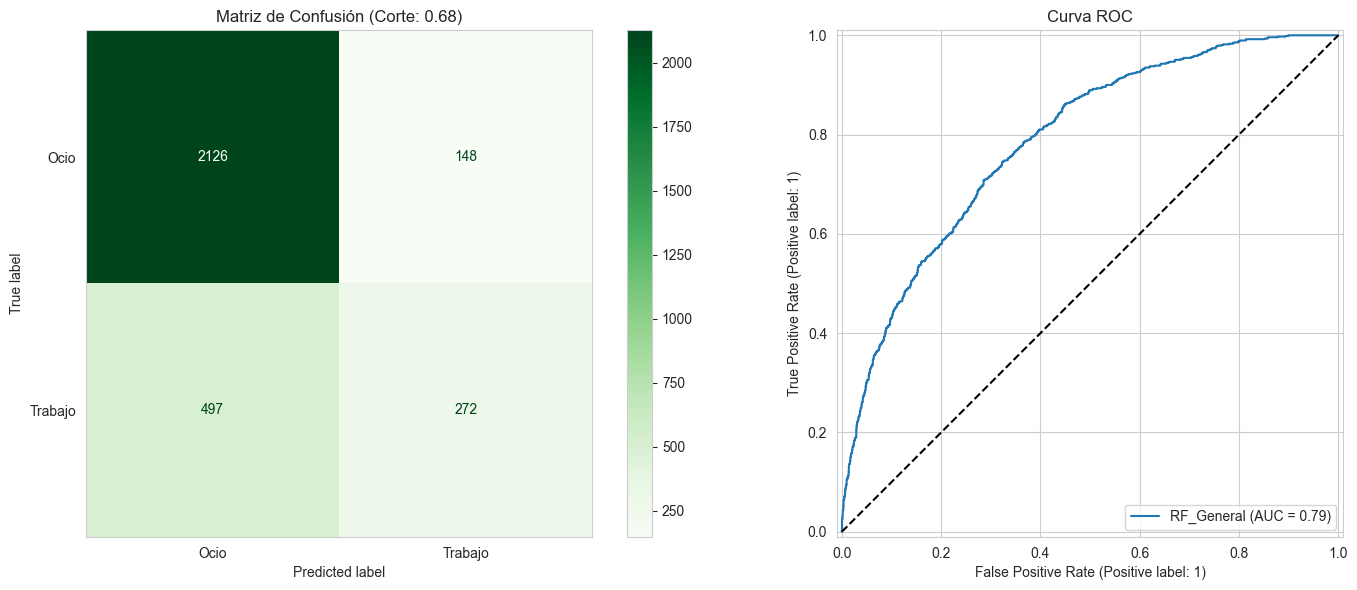

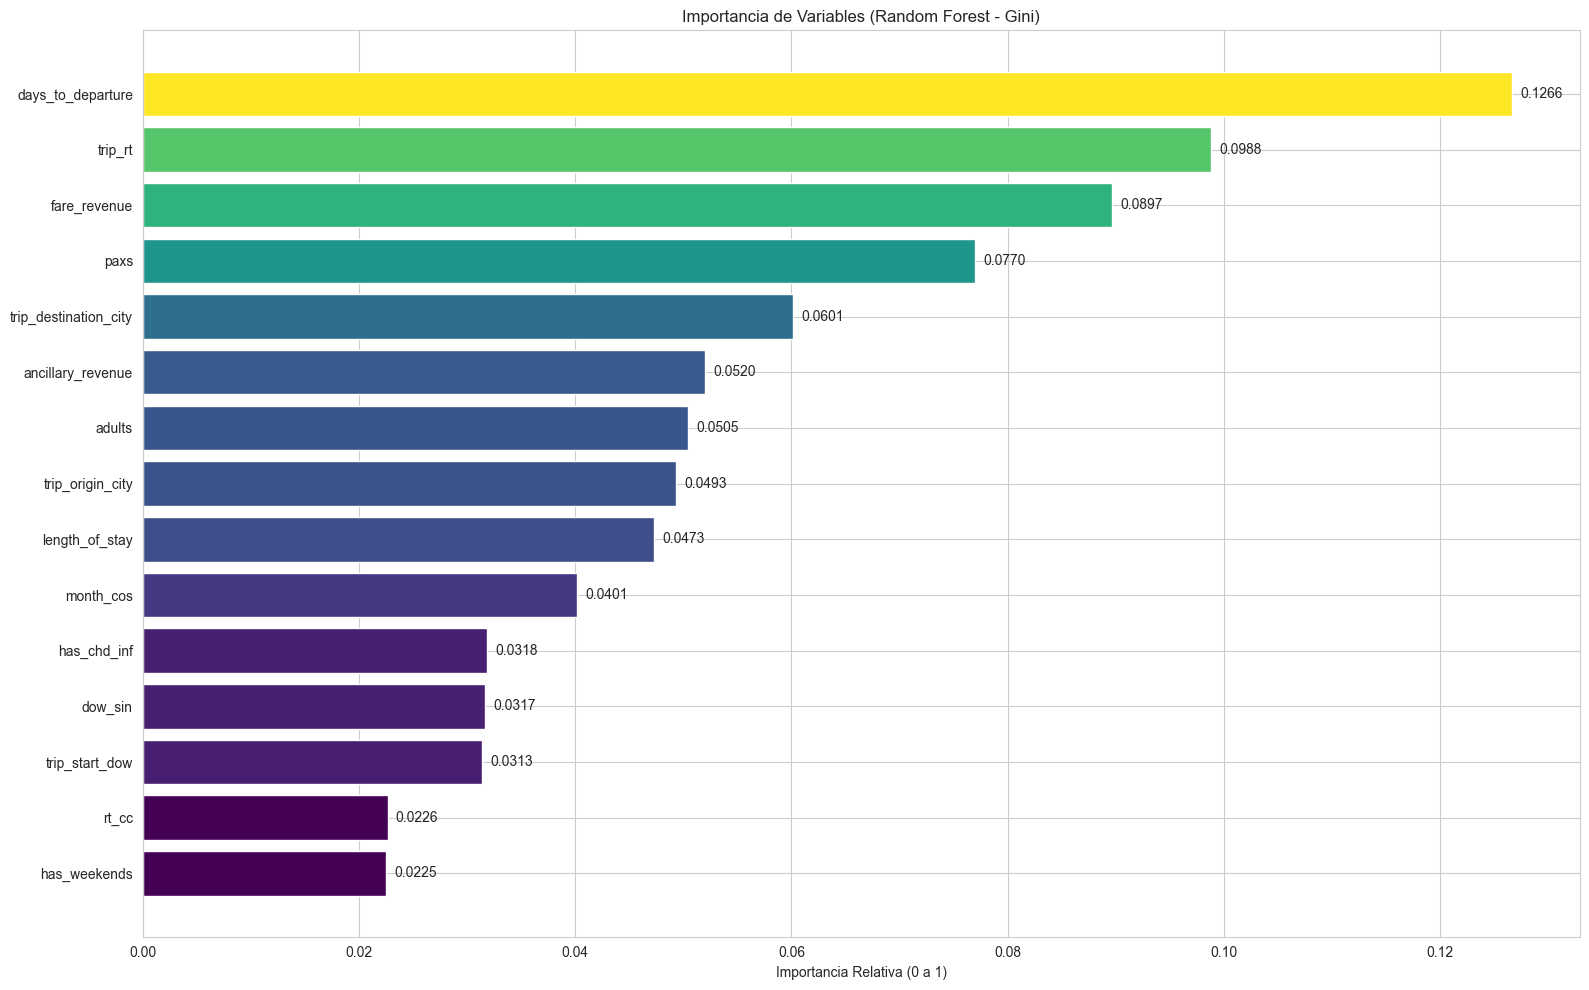

In [30]:
modelo = 'General'

X_train_general = pd.read_parquet(f'{DATA_DIR}X_train_{modelo}_encoded.parquet')# .drop(['days_to_departure'], axis=1)
X_test_general = pd.read_parquet(f'{DATA_DIR}X_test_{modelo}_encoded.parquet')# .drop(['days_to_departure'], axis=1)
y_train_general = pd.read_pickle(f'{DATA_DIR}y_train_{modelo}.pkl')
y_test_general = pd.read_pickle(f'{DATA_DIR}y_test_{modelo}.pkl')

# Entrenar
pack_rf_general = entrenar_rf_visual(
    X_train_general, X_test_general, y_train_general, y_test_general, 'RF_General', PARAMS_ESTATICOS['GENERAL']
)

# Graficar Importancia
graficar_importancia_rf(pack_rf_general, X_train_general.columns)

Cargando Chile...
PROCESANDO RANDOM FOREST: RF_Chile
-> Entrenando bosque con 400 árboles...

REPORTE FINAL (RF_Chile)
              precision    recall  f1-score   support

        Ocio       0.78      0.92      0.85       298
     Trabajo       0.78      0.52      0.63       159

    accuracy                           0.78       457
   macro avg       0.78      0.72      0.74       457
weighted avg       0.78      0.78      0.77       457

AUC-ROC Score: 0.8652


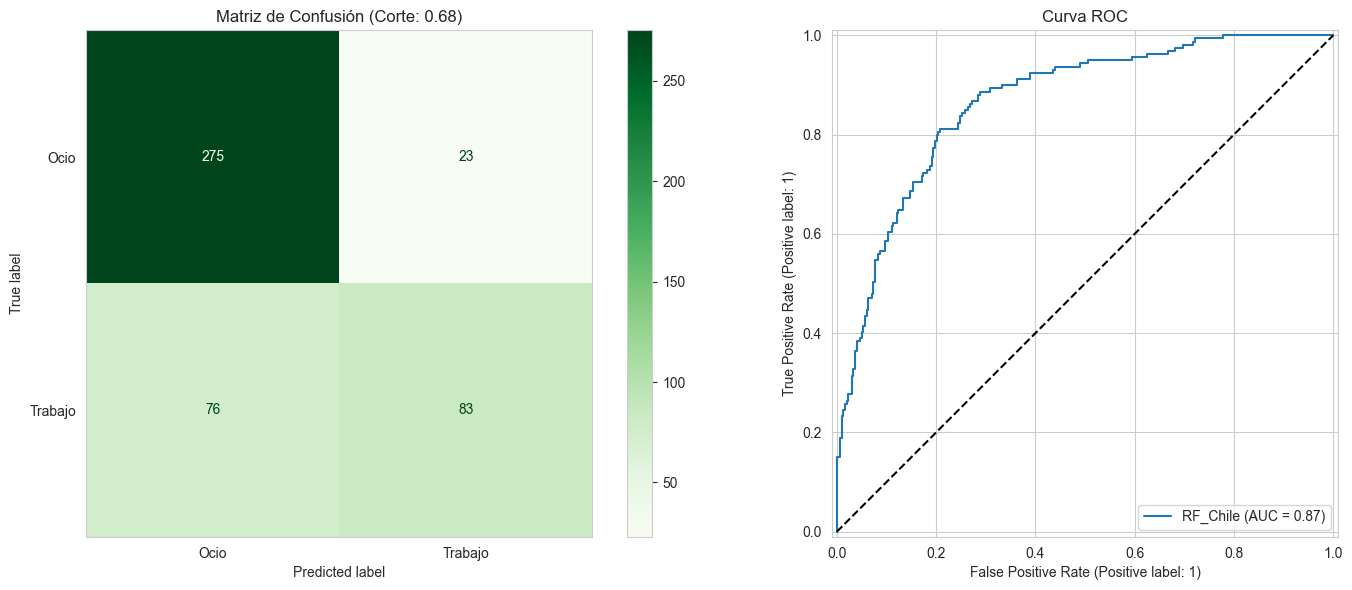

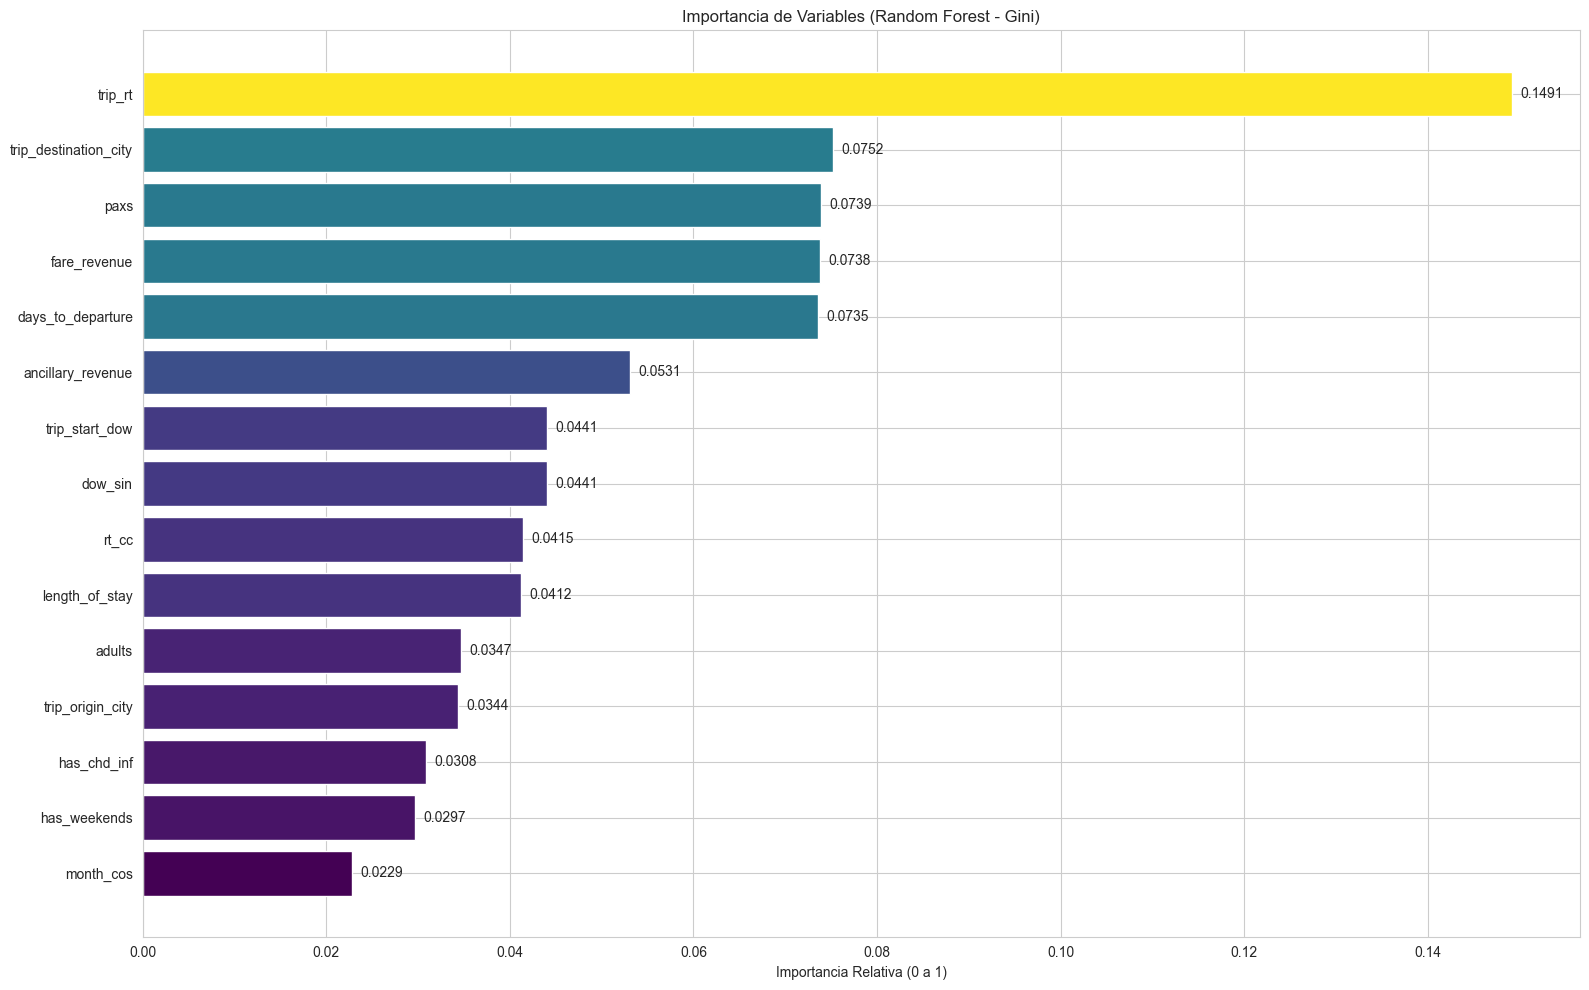

In [38]:
print("Cargando Chile...")
# Asegúrate que el nombre del archivo coincida con lo generado en el 01
X_train_chile = pd.read_parquet(f'{DATA_DIR}X_train_{MODELOCL}_encoded.parquet')# .drop(['trip_rt'], axis=1)
X_test_chile = pd.read_parquet(f'{DATA_DIR}X_test_{MODELOCL}_encoded.parquet')# .drop(['trip_rt'], axis=1)
y_train_chile = pd.read_pickle(f'{DATA_DIR}y_train_{MODELOCL}.pkl')
y_test_chile = pd.read_pickle(f'{DATA_DIR}y_test_{MODELOCL}.pkl')


pack_rf_cl = entrenar_rf_visual(
    X_train_chile, X_test_chile, y_train_chile, y_test_chile,
    "RF_Chile", PARAMS_ESTATICOS['CL']
)

graficar_importancia_rf(pack_rf_cl, X_train_chile.columns)


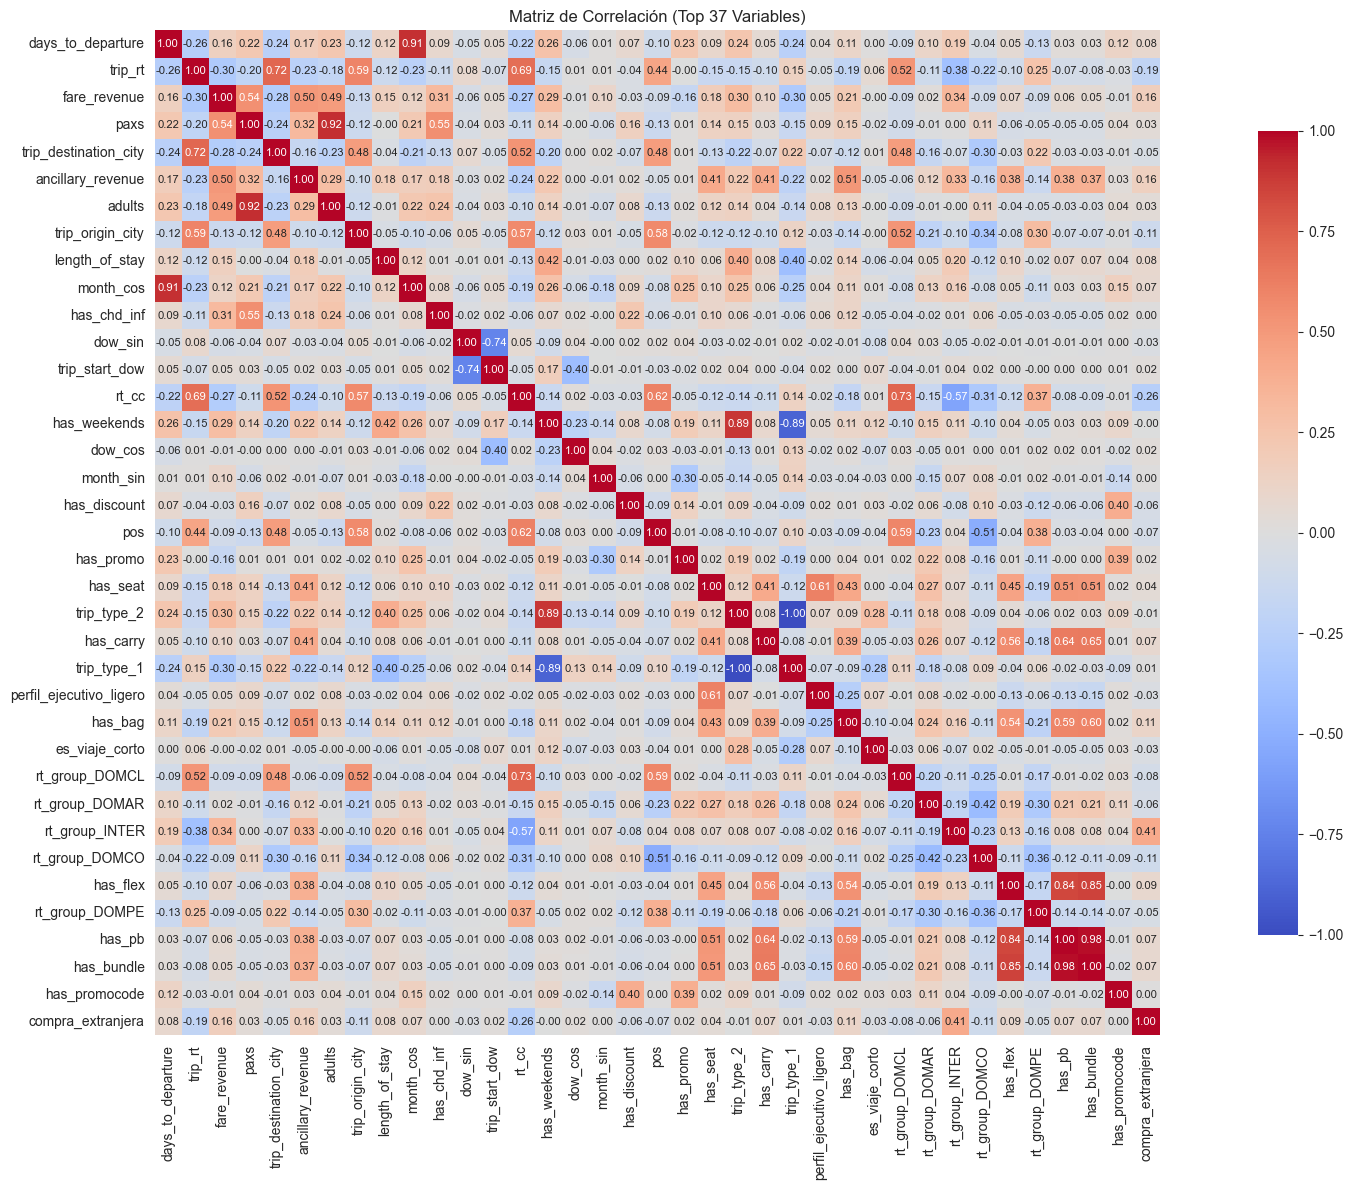

,days_to_departure,trip_rt,fare_revenue,paxs,trip_destination_city,ancillary_revenue,adults,trip_origin_city,length_of_stay,month_cos,has_chd_inf,dow_sin,trip_start_dow,rt_cc,has_weekends,dow_cos,month_sin,has_discount,pos,has_promo,has_seat,trip_type_2,has_carry,trip_type_1,perfil_ejecutivo_ligero,has_bag,es_viaje_corto,rt_group_DOMCL,rt_group_DOMAR,rt_group_INTER,rt_group_DOMCO,has_flex,rt_group_DOMPE,has_pb,has_bundle,has_promocode,compra_extranjera
days_to_departure,1.000000,-0.260050,0.155187,0.224677,-0.235767,0.174145,0.231672,-0.115409,0.122662,0.910585,0.085236,-0.051523,0.049860,-0.217544,0.258098,-0.057508,0.009686,0.070764,-0.098990,0.225216,0.089344,0.241717,0.050556,-0.241717,0.036200,0.106721,0.001616,-0.085604,0.104168,0.190827,-0.044293,0.052743,-0.134288,0.027544,0.028638,0.118005,0.082942
trip_rt,-0.260050,1.000000,-0.303003,-0.195731,0.721757,-0.227593,-0.184660,0.594519,-0.119024,-0.232226,-0.114947,0.080654,-0.068519,0.693962,-0.152405,0.006155,0.008819,-0.035915,0.439025,-0.002177,-0.148335,-0.148362,-0.102243,0.148362,-0.046182,-0.191240,0.062351,0.522205,-0.106190,-0.377936,-0.222908,-0.098077,0.253054,-0.071824,-0.075647,-0.028144,-0.190762
fare_revenue,0.155187,-0.303003,1.000000,0.544439,-0.277480,0.500818,0.490914,-0.126158,0.149124,0.123515,0.312745,-0.057357,0.046058,-0.274627,0.290456,-0.009479,0.099811,-0.032394,-0.089461,-0.157041,0.178188,0.302820,0.098590,-0.302820,0.051757,0.208414,-0.000382,-0.093612,0.017244,0.341318,-0.087051,0.070392,-0.093148,0.055672,0.054040,-0.014379,0.164773
paxs,0.224677,-0.195731,0.544439,1.000000,-0.237376,0.321285,0.916993,-0.122447,-0.001426,0.214849,0.553928,-0.039339,0.034753,-0.107239,0.143961,-0.003267,-0.059059,0.155411,-0.127087,0.010596,0.136921,0.146378,0.031544,-0.146378,0.086167,0.149263,-0.018946,-0.089907,-0.010590,0.003769,0.111663,-0.055237,-0.053721,-0.046462,-0.045057,0.042207,0.033804
trip_destination_city,-0.235767,0.721757,-0.277480,-0.237376,1.000000,-0.159550,-0.226391,0.481040,-0.036019,-0.213437,-0.130463,0.065256,-0.051421,0.524137,-0.197151,0.001634,0.019821,-0.073555,0.483996,0.012686,-0.128978,-0.215459,-0.070549,0.215459,-0.066845,-0.122867,0.011113,0.476791,-0.158680,-0.072899,-0.303271,-0.034843,0.217245,-0.025946,-0.029429,-0.011765,-0.046601
ancillary_revenue,0.174145,-0.227593,0.500818,0.321285,-0.159550,1.000000,0.294342,-0.104726,0.180163,0.166017,0.179459,-0.030409,0.019601,-0.242376,0.222484,0.002616,-0.014267,0.024927,-0.053484,0.014040,0.414506,0.216243,0.406429,-0.216243,0.019952,0.507842,-0.049218,-0.056822,0.115131,0.331280,-0.156541,0.375979,-0.138455,0.377742,0.374989,0.028326,0.155699
adults,0.231672,-0.184660,0.490914,0.916993,-0.226391,0.294342,1.000000,-0.118889,-0.008530,0.223928,0.243786,-0.037580,0.031945,-0.102089,0.138571,-0.012316,-0.069400,0.083499,-0.125425,0.017978,0.123789,0.144876,0.044402,-0.144876,0.083073,0.125217,-0.001434,-0.090645,-0.012594,-0.001752,0.114013,-0.044173,-0.049734,-0.032610,-0.031220,0.043049,0.034430
trip_origin_city,-0.115409,0.594519,-0.126158,-0.122447,0.481040,-0.104726,-0.118889,1.000000,-0.045353,-0.095811,-0.061808,0.051596,-0.054259,0.571428,-0.115309,0.026696,0.010283,-0.048685,0.576132,-0.016722,-0.117798,-0.123653,-0.095892,0.123653,-0.034913,-0.137452,-0.002710,0.519201,-0.208382,-0.102653,-0.338929,-0.076462,0.302220,-0.066750,-0.070533,-0.011740,-0.110896
length_of_stay,0.122662,-0.119024,0.149124,-0.001426,-0.036019,0.180163,-0.008530,-0.045353,1.000000,0.117996,0.012317,-0.005324,0.005954,-0.130097,0.416451,-0.012795,-0.026737,0.002345,0.018045,0.096274,0.058186,0.395885,0.079228,-0.395885,-0.023110,0.135437,-0.063670,-0.044545,0.047301,0.200707,-0.118638,0.100215,-0.023925,0.070479,0.071777,0.035843,0.078143
month_cos,0.910585,-0.232226,0.123515,0.214849,-0.213437,0.166017,0.223928,-0.095811,0.117996,1.000000,0.075607,-0.055794,0.053724,-0.185222,0.260400,-0.064147,-0.178541,0.086259,-0.075984,0.253045,0.100155,0.247549,0.058928,-0.247549,0.042543,0.111720,0.01386

In [32]:
matriz_correlacion(pack_rf_general, X_train_general)

In [39]:
# 2. Definir el Modelo (Decision Tree)
model_dt = DecisionTreeClassifier(
    max_depth=5,                # Mantiene el SQL corto y legible
    class_weight='balanced',    # Mantiene el foco en Negocios (Decimales)
    criterion='gini',           # Estándar y rápido
    min_samples_leaf=50,        # Exige evidencia mínima (Regla de oro)
    min_samples_split=100,      # No dividas grupos pequeños
    random_state=SEED           # Siempre 42 para reproducibilidad
)

# 3. Entrenar
model_dt.fit(X_train_chile, y_train_chile)

UMBRAL_DT = 0.6752

# 4. Evaluar
y_pred_proba_dt = model_dt.predict_proba(X_test_chile)[:, 1]
y_pred_final_dt = (y_pred_proba_dt > UMBRAL_DT).astype(int)

# 5. Calcular AUC
auc_score = roc_auc_score(y_test_chile, y_pred_proba_dt)


print("Reporte del Árbol de Decisión:")
print(f"Área bajo la curva (AUC): {auc_score:.4f}")
print(classification_report(y_test_chile, y_pred_final_dt))


Reporte del Árbol de Decisión:
Área bajo la curva (AUC): 0.8301
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       298
           1       0.73      0.48      0.58       159

    accuracy                           0.76       457
   macro avg       0.75      0.69      0.71       457
weighted avg       0.75      0.76      0.74       457



In [40]:
def exportar_arbol_svg_pro(modelo, feature_names, profundidad=5, nombre_archivo="arbol_decision_pro2"):
    """
    Exporta el árbol a SVG optimizado para lectura de negocio (limpio y con guía).
    """

    # 1. Configuración de Tamaño Dinámico (Un poco más ancho para que respire)
    ancho = 55 + (profundidad * 5)
    alto = 10 + (profundidad * 2)

    # Creamos la figura
    fig, ax = plt.subplots(figsize=(ancho, alto))

    print(f"Dibujando árbol limpio (Depth={profundidad})...")

    # 2. Dibujar el Árbol (Configuración "Clean")
    plot_tree(
        modelo,
        feature_names=feature_names,
        class_names=['Ocio', 'Trabajo'],
        filled=True,                     # Colores para distinguir clases
        rounded=True,                    # Cajas con bordes redondeados
        max_depth=profundidad,
        fontsize=11,                     # Letra un poco más grande
        node_ids=False,                  # No mostrar ID de nodo
        proportion=False,                # False = Muestra cantidad de personas (Samples). True = Porcentajes.
        precision=3,                     # Menos decimales = Más limpieza
    )

    # 3. EL TRUCO: Agregar la leyenda de "True/False" manual
    # Esto dibuja una caja de texto explicativa en la parte superior
    ax.text(
        0.5, 1.00, # Posición (x=Centro, y=Arriba del todo)
        "GUÍA DE LECTURA:\nIzquierda: La condición es VERDADERA (SÍ)   |   Derecha: La condición es FALSA (NO)",
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes,
        fontsize=11,
        fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.5')
    )

    # Aseguramos extensión
    if not nombre_archivo.endswith('.svg'):
        nombre_archivo += '.svg'

    # Guardar
    plt.savefig(nombre_archivo, format='svg', bbox_inches='tight')
    plt.close()

    print(f"¡Árbol Pro generado!: {nombre_archivo}")


In [41]:

# --- EJEMPLO DE USO ---
exportar_arbol_svg_pro(
    model_dt,  # Tu modelo optimizado (el de profundidad 4)
    feature_names=X_train_chile.columns.tolist(),
    profundidad=5,
    nombre_archivo="Arbol_Segmentacion_Chile",

)

Dibujando árbol limpio (Depth=5)...
¡Árbol Pro generado!: Arbol_Segmentacion_Chile.svg


In [42]:
def obtener_reglas_texto(modelo, feature_names):
    """
    Extrae las reglas del árbol en formato texto legible
    """
    reglas = export_text(modelo, feature_names=list(feature_names))
    print(reglas)

obtener_reglas_texto(model_dt, X_train_chile.columns)

|--- trip_rt <= 0.34
|   |--- days_to_departure <= 9.50
|   |   |--- trip_destination_city <= 0.19
|   |   |   |--- class: 0
|   |   |--- trip_destination_city >  0.19
|   |   |   |--- trip_rt <= 0.31
|   |   |   |   |--- has_weekends <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- has_weekends >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- trip_rt >  0.31
|   |   |   |   |--- ancillary_revenue <= 12.91
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- ancillary_revenue >  12.91
|   |   |   |   |   |--- class: 1
|   |--- days_to_departure >  9.50
|   |   |--- trip_destination_city <= 0.20
|   |   |   |--- days_to_departure <= 109.50
|   |   |   |   |--- length_of_stay <= 5.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- length_of_stay >  5.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- days_to_departure >  109.50
|   |   |   |   |--- month_cos <= 0.93
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- month_cos >  0.93
|   |   |   | 